# Empirical Data Inference
Infer evolutionary parameters from empirical data with the ensemble density estimators.

In [1]:
import torch
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from cheating_MACHA import simulate
from utils import get_ensemble_predictions, calc_stats, sbi_post, get_mode_and_hdi, grab_short_sumstat, grab_long_sumstat, grab_man_sumstat
from model.params import wide_fit_prior as prior 
from plotting import plot_from_post, set_plots_size_params, compare_posts, short_sumstats_plot, compare_posts_across_lines
set_plots_size_params(20)

In [2]:
rename_dict = {'mu': 'Mutation\nRate', 'w_syn': 'Syn\nEffect', 'w_non_syn': 'Non-Syn\nEffect',
               'w_ada': 'Beneficial\nEffect', 'p_ada_syn': 'Beneficial\nSyn\nProbability',
               'p_ada_non_syn': 'Beneficial\nNon-Syn\nProbability', 'p0_syn': 'P0 Syn',
               'p0_non_syn': 'P0\nNon-Syn', 'w_penalty': 'P0 Penalty', 
               'epistasis_boost': 'Epistasis\nFitness\nBoost'}

In [3]:
def infer_and_plot(ensemble_path, input_data, man_sumstat, syn_prob, sumstats_to_simulate=10,
                   plot_hdi=True, plot_short_PPC=True, plot_long_PPC=True, plot_freqs=True, samples_per_model=200):
    post, stats = get_ensemble_predictions(ensemble_path, input_data, None, prior, samples_per_model=samples_per_model)
    print(stats[stats.model=='ensemble'])
    post = post.rename(columns=rename_dict)
    post = post[rename_dict.values()]
    simulated_data = plot_from_post(post, stats, man_sumstat, num_of_samples=sumstats_to_simulate, syn_prob=syn_prob,
                                    plot_hdi=plot_hdi, plot_short_PPC=plot_short_PPC, plot_freqs=plot_freqs,
                                    plot_long_PPC=plot_long_PPC)
    return post, stats, simulated_data


In [4]:
# EB=1 --> no epistasis!, 0<EB<1 --> weak negative, EB<0 --> sign epistasis!
# PP=0 --> P0 muts are neutral, PP=1 --> P0 muts are not as deleterious as the rest of the muts

In [5]:
loop_coding = {}
loop_coding_short = {}
loop_coding_man = {}

def grab_long(sumstat):
    return sumstat[:204]

def grab_short(sumstat):
    return sumstat[:6]

def grab_man(sumstat):
    return np.concatenate((sumstat[:6],sumstat[204:]))

line_replica = {1: 'A', 2: 'B', 3: 'C'}

for i in range(1,4):
    total_coding_sumstat = torch.load(join('data_analysis', line{i}_total_sumstat.pt))
    loop_coding[line_replica[i]] = grab_long(total_coding_sumstat)
    loop_coding_man[line_replica[i]] = grab_man(total_coding_sumstat)
    loop_coding_short[line_replica[i]] = grab_short(total_coding_sumstat)

syn_prob = 0.278

In [6]:
def get_ensemble_path(errs, replica, sumstat_type):
    return join('density_estimators', f'{errs} error rate', replica, sumstat_type)

# LR Inference

In [7]:
inf_LR = {}

In [8]:
errs = '5e-05'
sumstat_type = 'LR'
replica = 'A'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LR[replica] = infer_and_plot(ensemble_path, loop_coding[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Getting posterior from sumstat:
tensor([6.0600e-01, 8.2083e-01, 7.2008e-01, 1.0507e+00, 7.8417e-01, 1.3471e+00,
        2.8612e-01, 2.0024e-01, 1.0072e-01, 1.1538e-01, 1.0415e-01, 6.5647e-02,
        2.3452e-02, 3.1931e-02, 2.6978e-02, 3.7523e-03, 3.8794e-03, 2.6978e-03,
        0.0000e+00, 5.9684e-04, 2.6978e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9137e-01, 1.7786e-01, 2.0953e-01,
        1.3321e-01, 1.3578e-01, 1.3489e-01, 4.6904e-02, 4.5956e-02, 4.7662e-02,
        5.6285e-03, 9.8478e-03, 1.5288e-02, 3.7523e-03, 2.0889e-03, 3.5971e-03,
        0.0000e+00, 0.0000e+00, 1.7986e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9719e-02, 7.2814e-02, 1.0612e-01,
        

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([6.0600e-01, 8.2083e-01, 7.2008e-01, 1.0507e+00, 7.8417e-01, 1.3471e+00,
        2.8612e-01, 2.0024e-01, 1.0072e-01, 1.1538e-01, 1.0415e-01, 6.5647e-02,
        2.3452e-02, 3.1931e-02, 2.6978e-02, 3.7523e-03, 3.8794e-03, 2.6978e-03,
        0.0000e+00, 5.9684e-04, 2.6978e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9137e-01, 1.7786e-01, 2.0953e-01,
        1.3321e-01, 1.3578e-01, 1.3489e-01, 4.6904e-02, 4.5956e-02, 4.7662e-02,
        5.6285e-03, 9.8478e-03, 1.5288e-02, 3.7523e-03, 2.0889e-03, 3.5971e-03,
        0.0000e+00, 0.0000e+00, 1.7986e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9719e-02, 7.2814e-02, 1.0612e-01,
        

/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([6.0600e-01, 8.2083e-01, 7.2008e-01, 1.0507e+00, 7.8417e-01, 1.3471e+00,
        2.8612e-01, 2.0024e-01, 1.0072e-01, 1.1538e-01, 1.0415e-01, 6.5647e-02,
        2.3452e-02, 3.1931e-02, 2.6978e-02, 3.7523e-03, 3.8794e-03, 2.6978e-03,
        0.0000e+00, 5.9684e-04, 2.6978e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9137e-01, 1.7786e-01, 2.0953e-01,
        1.3321e-01, 1.3578e-01, 1.3489e-01, 4.6904e-02, 4.5956e-02, 4.7662e-02,
        5.6285e-03, 9.8478e-03, 1.5288e-02, 3.7523e-03, 2.0889e-03, 3.5971e-03,
        0.0000e+00, 0.0000e+00, 1.7986e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9719e-02, 7.2814e-02, 1.0612e-01,
        

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([6.0600e-01, 8.2083e-01, 7.2008e-01, 1.0507e+00, 7.8417e-01, 1.3471e+00,
        2.8612e-01, 2.0024e-01, 1.0072e-01, 1.1538e-01, 1.0415e-01, 6.5647e-02,
        2.3452e-02, 3.1931e-02, 2.6978e-02, 3.7523e-03, 3.8794e-03, 2.6978e-03,
        0.0000e+00, 5.9684e-04, 2.6978e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9137e-01, 1.7786e-01, 2.0953e-01,
        1.3321e-01, 1.3578e-01, 1.3489e-01, 4.6904e-02, 4.5956e-02, 4.7662e-02,
        5.6285e-03, 9.8478e-03, 1.5288e-02, 3.7523e-03, 2.0889e-03, 3.5971e-03,
        0.0000e+00, 0.0000e+00, 1.7986e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9719e-02, 7.2814e-02, 1.0612e-01,
        

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([6.0600e-01, 8.2083e-01, 7.2008e-01, 1.0507e+00, 7.8417e-01, 1.3471e+00,
        2.8612e-01, 2.0024e-01, 1.0072e-01, 1.1538e-01, 1.0415e-01, 6.5647e-02,
        2.3452e-02, 3.1931e-02, 2.6978e-02, 3.7523e-03, 3.8794e-03, 2.6978e-03,
        0.0000e+00, 5.9684e-04, 2.6978e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9137e-01, 1.7786e-01, 2.0953e-01,
        1.3321e-01, 1.3578e-01, 1.3489e-01, 4.6904e-02, 4.5956e-02, 4.7662e-02,
        5.6285e-03, 9.8478e-03, 1.5288e-02, 3.7523e-03, 2.0889e-03, 3.5971e-03,
        0.0000e+00, 0.0000e+00, 1.7986e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9719e-02, 7.2814e-02, 1.0612e-01,
        

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([6.0600e-01, 8.2083e-01, 7.2008e-01, 1.0507e+00, 7.8417e-01, 1.3471e+00,
        2.8612e-01, 2.0024e-01, 1.0072e-01, 1.1538e-01, 1.0415e-01, 6.5647e-02,
        2.3452e-02, 3.1931e-02, 2.6978e-02, 3.7523e-03, 3.8794e-03, 2.6978e-03,
        0.0000e+00, 5.9684e-04, 2.6978e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9137e-01, 1.7786e-01, 2.0953e-01,
        1.3321e-01, 1.3578e-01, 1.3489e-01, 4.6904e-02, 4.5956e-02, 4.7662e-02,
        5.6285e-03, 9.8478e-03, 1.5288e-02, 3.7523e-03, 2.0889e-03, 3.5971e-03,
        0.0000e+00, 0.0000e+00, 1.7986e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9719e-02, 7.2814e-02, 1.0612e-01,
        

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([6.0600e-01, 8.2083e-01, 7.2008e-01, 1.0507e+00, 7.8417e-01, 1.3471e+00,
        2.8612e-01, 2.0024e-01, 1.0072e-01, 1.1538e-01, 1.0415e-01, 6.5647e-02,
        2.3452e-02, 3.1931e-02, 2.6978e-02, 3.7523e-03, 3.8794e-03, 2.6978e-03,
        0.0000e+00, 5.9684e-04, 2.6978e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9137e-01, 1.7786e-01, 2.0953e-01,
        1.3321e-01, 1.3578e-01, 1.3489e-01, 4.6904e-02, 4.5956e-02, 4.7662e-02,
        5.6285e-03, 9.8478e-03, 1.5288e-02, 3.7523e-03, 2.0889e-03, 3.5971e-03,
        0.0000e+00, 0.0000e+00, 1.7986e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9719e-02, 7.2814e-02, 1.0612e-01,
        

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([6.0600e-01, 8.2083e-01, 7.2008e-01, 1.0507e+00, 7.8417e-01, 1.3471e+00,
        2.8612e-01, 2.0024e-01, 1.0072e-01, 1.1538e-01, 1.0415e-01, 6.5647e-02,
        2.3452e-02, 3.1931e-02, 2.6978e-02, 3.7523e-03, 3.8794e-03, 2.6978e-03,
        0.0000e+00, 5.9684e-04, 2.6978e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9137e-01, 1.7786e-01, 2.0953e-01,
        1.3321e-01, 1.3578e-01, 1.3489e-01, 4.6904e-02, 4.5956e-02, 4.7662e-02,
        5.6285e-03, 9.8478e-03, 1.5288e-02, 3.7523e-03, 2.0889e-03, 3.5971e-03,
        0.0000e+00, 0.0000e+00, 1.7986e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9719e-02, 7.2814e-02, 1.0612e-01,
        

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode     hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.758000 -2.109643e+00  1.481014    0.118284  -1.130702   
1            w_syn  0.947000  4.904083e-01  1.043546    0.999995   0.846479   
2        w_non_syn  0.788000  2.314667e-01  0.723883    0.982539   0.629621   
3            w_ada  1.713000  1.159443e+00  0.825196    2.534195   1.446145   
4        p_ada_syn  0.000835  5.907005e-08  1.292897    0.003432   0.000115   
5    p_ada_non_syn  0.007555  2.691951e-03  0.712316    0.009994   0.005324   
6           p0_syn  0.557000  4.476113e-01  0.707076    0.599251   0.506339   
7       p0_non_syn  0.783000  7.025862e-01  0.636302    0.876844   0.753596   
8        w_penalty  0.049850  3.667072e-05  1.162836    1.139182   0.000223   
9  epistasis_boost  0.176000 -8.971927e-01  0.485564    1.556011  -0.091702   

   hdi50_high     model  
0   -0.398075  ensemble  
1    0.995629  ensemble  
2    0.911820  ensemble  
3    1.887185  ensemble  


In [9]:
errs = '5e-05'
sumstat_type = 'LR'
replica = 'B'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LR[replica] = infer_and_plot(ensemble_path, loop_coding[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Getting posterior from sumstat:
tensor([5.8468e-01, 8.0667e-01, 6.7026e-01, 9.5044e-01, 7.7615e-01, 1.2092e+00,
        2.9338e-01, 2.2179e-01, 1.0349e-01, 1.1516e-01, 1.2022e-01, 8.7739e-02,
        1.8239e-02, 3.0913e-02, 2.9246e-02, 2.6055e-03, 2.9441e-03, 5.6243e-03,
        5.2110e-04, 9.8135e-04, 1.1249e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8760e-01, 1.8155e-01, 2.0585e-01,
        1.4591e-01, 1.3837e-01, 1.5973e-01, 3.6477e-02, 4.3670e-02, 5.7368e-02,
        8.8588e-03, 7.8508e-03, 1.4623e-02, 2.0844e-03, 2.4534e-03, 2.2497e-03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.8463e-02, 7.4583e-02, 1.1024e-01,
        

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([5.8468e-01, 8.0667e-01, 6.7026e-01, 9.5044e-01, 7.7615e-01, 1.2092e+00,
        2.9338e-01, 2.2179e-01, 1.0349e-01, 1.1516e-01, 1.2022e-01, 8.7739e-02,
        1.8239e-02, 3.0913e-02, 2.9246e-02, 2.6055e-03, 2.9441e-03, 5.6243e-03,
        5.2110e-04, 9.8135e-04, 1.1249e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8760e-01, 1.8155e-01, 2.0585e-01,
        1.4591e-01, 1.3837e-01, 1.5973e-01, 3.6477e-02, 4.3670e-02, 5.7368e-02,
        8.8588e-03, 7.8508e-03, 1.4623e-02, 2.0844e-03, 2.4534e-03, 2.2497e-03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.8463e-02, 7.4583e-02, 1.1024e-01,
        

/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([5.8468e-01, 8.0667e-01, 6.7026e-01, 9.5044e-01, 7.7615e-01, 1.2092e+00,
        2.9338e-01, 2.2179e-01, 1.0349e-01, 1.1516e-01, 1.2022e-01, 8.7739e-02,
        1.8239e-02, 3.0913e-02, 2.9246e-02, 2.6055e-03, 2.9441e-03, 5.6243e-03,
        5.2110e-04, 9.8135e-04, 1.1249e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8760e-01, 1.8155e-01, 2.0585e-01,
        1.4591e-01, 1.3837e-01, 1.5973e-01, 3.6477e-02, 4.3670e-02, 5.7368e-02,
        8.8588e-03, 7.8508e-03, 1.4623e-02, 2.0844e-03, 2.4534e-03, 2.2497e-03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.8463e-02, 7.4583e-02, 1.1024e-01,
        

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([5.8468e-01, 8.0667e-01, 6.7026e-01, 9.5044e-01, 7.7615e-01, 1.2092e+00,
        2.9338e-01, 2.2179e-01, 1.0349e-01, 1.1516e-01, 1.2022e-01, 8.7739e-02,
        1.8239e-02, 3.0913e-02, 2.9246e-02, 2.6055e-03, 2.9441e-03, 5.6243e-03,
        5.2110e-04, 9.8135e-04, 1.1249e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8760e-01, 1.8155e-01, 2.0585e-01,
        1.4591e-01, 1.3837e-01, 1.5973e-01, 3.6477e-02, 4.3670e-02, 5.7368e-02,
        8.8588e-03, 7.8508e-03, 1.4623e-02, 2.0844e-03, 2.4534e-03, 2.2497e-03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.8463e-02, 7.4583e-02, 1.1024e-01,
        

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([5.8468e-01, 8.0667e-01, 6.7026e-01, 9.5044e-01, 7.7615e-01, 1.2092e+00,
        2.9338e-01, 2.2179e-01, 1.0349e-01, 1.1516e-01, 1.2022e-01, 8.7739e-02,
        1.8239e-02, 3.0913e-02, 2.9246e-02, 2.6055e-03, 2.9441e-03, 5.6243e-03,
        5.2110e-04, 9.8135e-04, 1.1249e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8760e-01, 1.8155e-01, 2.0585e-01,
        1.4591e-01, 1.3837e-01, 1.5973e-01, 3.6477e-02, 4.3670e-02, 5.7368e-02,
        8.8588e-03, 7.8508e-03, 1.4623e-02, 2.0844e-03, 2.4534e-03, 2.2497e-03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.8463e-02, 7.4583e-02, 1.1024e-01,
        

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([5.8468e-01, 8.0667e-01, 6.7026e-01, 9.5044e-01, 7.7615e-01, 1.2092e+00,
        2.9338e-01, 2.2179e-01, 1.0349e-01, 1.1516e-01, 1.2022e-01, 8.7739e-02,
        1.8239e-02, 3.0913e-02, 2.9246e-02, 2.6055e-03, 2.9441e-03, 5.6243e-03,
        5.2110e-04, 9.8135e-04, 1.1249e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8760e-01, 1.8155e-01, 2.0585e-01,
        1.4591e-01, 1.3837e-01, 1.5973e-01, 3.6477e-02, 4.3670e-02, 5.7368e-02,
        8.8588e-03, 7.8508e-03, 1.4623e-02, 2.0844e-03, 2.4534e-03, 2.2497e-03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.8463e-02, 7.4583e-02, 1.1024e-01,
        

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([5.8468e-01, 8.0667e-01, 6.7026e-01, 9.5044e-01, 7.7615e-01, 1.2092e+00,
        2.9338e-01, 2.2179e-01, 1.0349e-01, 1.1516e-01, 1.2022e-01, 8.7739e-02,
        1.8239e-02, 3.0913e-02, 2.9246e-02, 2.6055e-03, 2.9441e-03, 5.6243e-03,
        5.2110e-04, 9.8135e-04, 1.1249e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8760e-01, 1.8155e-01, 2.0585e-01,
        1.4591e-01, 1.3837e-01, 1.5973e-01, 3.6477e-02, 4.3670e-02, 5.7368e-02,
        8.8588e-03, 7.8508e-03, 1.4623e-02, 2.0844e-03, 2.4534e-03, 2.2497e-03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.8463e-02, 7.4583e-02, 1.1024e-01,
        

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([5.8468e-01, 8.0667e-01, 6.7026e-01, 9.5044e-01, 7.7615e-01, 1.2092e+00,
        2.9338e-01, 2.2179e-01, 1.0349e-01, 1.1516e-01, 1.2022e-01, 8.7739e-02,
        1.8239e-02, 3.0913e-02, 2.9246e-02, 2.6055e-03, 2.9441e-03, 5.6243e-03,
        5.2110e-04, 9.8135e-04, 1.1249e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8760e-01, 1.8155e-01, 2.0585e-01,
        1.4591e-01, 1.3837e-01, 1.5973e-01, 3.6477e-02, 4.3670e-02, 5.7368e-02,
        8.8588e-03, 7.8508e-03, 1.4623e-02, 2.0844e-03, 2.4534e-03, 2.2497e-03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.8463e-02, 7.4583e-02, 1.1024e-01,
        

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param     mode     hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.53450 -1.403888e+00  1.097471    0.195037  -0.884002   
1            w_syn  0.90600  4.147604e-01  0.887421    0.999945   0.749853   
2        w_non_syn  0.71800  2.325806e-01  0.717929    0.975757   0.576214   
3            w_ada  1.46200  1.105388e+00  1.012597    2.137803   1.306157   
4        p_ada_syn  0.00159  1.885602e-07  0.936364    0.005250   0.000589   
5    p_ada_non_syn  0.00608  2.542636e-03  0.700609    0.009977   0.005477   
6           p0_syn  0.51300  4.245209e-01  0.654717    0.593671   0.477713   
7       p0_non_syn  0.78300  7.051064e-01  0.634356    0.877296   0.747171   
8        w_penalty  0.07010  3.550880e-04  0.802247    1.495762   0.001749   
9  epistasis_boost  0.17850 -9.621977e-01  0.380037    1.943982  -0.116552   

   hdi50_high     model  
0   -0.319201  ensemble  
1    0.956438  ensemble  
2    0.868497  ensemble  
3    1.635185  ensemble  
4    0.0025

In [10]:
errs = '5e-05'
sumstat_type = 'LR'
replica = 'C'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LR[replica] = infer_and_plot(ensemble_path, loop_coding[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Getting posterior from sumstat:
tensor([5.8098e-01, 8.4576e-01, 6.3996e-01, 1.0010e+00, 7.7925e-01, 1.3856e+00,
        2.9357e-01, 2.3937e-01, 7.0880e-02, 1.0283e-01, 9.1988e-02, 6.6610e-02,
        1.7995e-02, 2.9674e-02, 2.7327e-02, 3.0848e-03, 4.9456e-03, 6.8318e-03,
        1.0283e-03, 9.8912e-04, 8.5397e-04, 0.0000e+00, 0.0000e+00, 4.2699e-04,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7841e-01, 1.8694e-01, 2.2716e-01,
        1.4190e-01, 1.2463e-01, 1.4774e-01, 4.7301e-02, 4.7478e-02, 4.6541e-02,
        8.7404e-03, 6.9238e-03, 8.5397e-03, 0.0000e+00, 9.8912e-04, 2.5619e-03,
        5.1414e-04, 0.0000e+00, 4.2699e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 6.1183e-02, 7.9130e-02, 1.1699e-01,
        

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([5.8098e-01, 8.4576e-01, 6.3996e-01, 1.0010e+00, 7.7925e-01, 1.3856e+00,
        2.9357e-01, 2.3937e-01, 7.0880e-02, 1.0283e-01, 9.1988e-02, 6.6610e-02,
        1.7995e-02, 2.9674e-02, 2.7327e-02, 3.0848e-03, 4.9456e-03, 6.8318e-03,
        1.0283e-03, 9.8912e-04, 8.5397e-04, 0.0000e+00, 0.0000e+00, 4.2699e-04,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7841e-01, 1.8694e-01, 2.2716e-01,
        1.4190e-01, 1.2463e-01, 1.4774e-01, 4.7301e-02, 4.7478e-02, 4.6541e-02,
        8.7404e-03, 6.9238e-03, 8.5397e-03, 0.0000e+00, 9.8912e-04, 2.5619e-03,
        5.1414e-04, 0.0000e+00, 4.2699e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 6.1183e-02, 7.9130e-02, 1.1699e-01,
        

/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([5.8098e-01, 8.4576e-01, 6.3996e-01, 1.0010e+00, 7.7925e-01, 1.3856e+00,
        2.9357e-01, 2.3937e-01, 7.0880e-02, 1.0283e-01, 9.1988e-02, 6.6610e-02,
        1.7995e-02, 2.9674e-02, 2.7327e-02, 3.0848e-03, 4.9456e-03, 6.8318e-03,
        1.0283e-03, 9.8912e-04, 8.5397e-04, 0.0000e+00, 0.0000e+00, 4.2699e-04,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7841e-01, 1.8694e-01, 2.2716e-01,
        1.4190e-01, 1.2463e-01, 1.4774e-01, 4.7301e-02, 4.7478e-02, 4.6541e-02,
        8.7404e-03, 6.9238e-03, 8.5397e-03, 0.0000e+00, 9.8912e-04, 2.5619e-03,
        5.1414e-04, 0.0000e+00, 4.2699e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 6.1183e-02, 7.9130e-02, 1.1699e-01,
        

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([5.8098e-01, 8.4576e-01, 6.3996e-01, 1.0010e+00, 7.7925e-01, 1.3856e+00,
        2.9357e-01, 2.3937e-01, 7.0880e-02, 1.0283e-01, 9.1988e-02, 6.6610e-02,
        1.7995e-02, 2.9674e-02, 2.7327e-02, 3.0848e-03, 4.9456e-03, 6.8318e-03,
        1.0283e-03, 9.8912e-04, 8.5397e-04, 0.0000e+00, 0.0000e+00, 4.2699e-04,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7841e-01, 1.8694e-01, 2.2716e-01,
        1.4190e-01, 1.2463e-01, 1.4774e-01, 4.7301e-02, 4.7478e-02, 4.6541e-02,
        8.7404e-03, 6.9238e-03, 8.5397e-03, 0.0000e+00, 9.8912e-04, 2.5619e-03,
        5.1414e-04, 0.0000e+00, 4.2699e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 6.1183e-02, 7.9130e-02, 1.1699e-01,
        

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([5.8098e-01, 8.4576e-01, 6.3996e-01, 1.0010e+00, 7.7925e-01, 1.3856e+00,
        2.9357e-01, 2.3937e-01, 7.0880e-02, 1.0283e-01, 9.1988e-02, 6.6610e-02,
        1.7995e-02, 2.9674e-02, 2.7327e-02, 3.0848e-03, 4.9456e-03, 6.8318e-03,
        1.0283e-03, 9.8912e-04, 8.5397e-04, 0.0000e+00, 0.0000e+00, 4.2699e-04,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7841e-01, 1.8694e-01, 2.2716e-01,
        1.4190e-01, 1.2463e-01, 1.4774e-01, 4.7301e-02, 4.7478e-02, 4.6541e-02,
        8.7404e-03, 6.9238e-03, 8.5397e-03, 0.0000e+00, 9.8912e-04, 2.5619e-03,
        5.1414e-04, 0.0000e+00, 4.2699e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 6.1183e-02, 7.9130e-02, 1.1699e-01,
        

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([5.8098e-01, 8.4576e-01, 6.3996e-01, 1.0010e+00, 7.7925e-01, 1.3856e+00,
        2.9357e-01, 2.3937e-01, 7.0880e-02, 1.0283e-01, 9.1988e-02, 6.6610e-02,
        1.7995e-02, 2.9674e-02, 2.7327e-02, 3.0848e-03, 4.9456e-03, 6.8318e-03,
        1.0283e-03, 9.8912e-04, 8.5397e-04, 0.0000e+00, 0.0000e+00, 4.2699e-04,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7841e-01, 1.8694e-01, 2.2716e-01,
        1.4190e-01, 1.2463e-01, 1.4774e-01, 4.7301e-02, 4.7478e-02, 4.6541e-02,
        8.7404e-03, 6.9238e-03, 8.5397e-03, 0.0000e+00, 9.8912e-04, 2.5619e-03,
        5.1414e-04, 0.0000e+00, 4.2699e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 6.1183e-02, 7.9130e-02, 1.1699e-01,
        

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([5.8098e-01, 8.4576e-01, 6.3996e-01, 1.0010e+00, 7.7925e-01, 1.3856e+00,
        2.9357e-01, 2.3937e-01, 7.0880e-02, 1.0283e-01, 9.1988e-02, 6.6610e-02,
        1.7995e-02, 2.9674e-02, 2.7327e-02, 3.0848e-03, 4.9456e-03, 6.8318e-03,
        1.0283e-03, 9.8912e-04, 8.5397e-04, 0.0000e+00, 0.0000e+00, 4.2699e-04,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7841e-01, 1.8694e-01, 2.2716e-01,
        1.4190e-01, 1.2463e-01, 1.4774e-01, 4.7301e-02, 4.7478e-02, 4.6541e-02,
        8.7404e-03, 6.9238e-03, 8.5397e-03, 0.0000e+00, 9.8912e-04, 2.5619e-03,
        5.1414e-04, 0.0000e+00, 4.2699e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 6.1183e-02, 7.9130e-02, 1.1699e-01,
        

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([5.8098e-01, 8.4576e-01, 6.3996e-01, 1.0010e+00, 7.7925e-01, 1.3856e+00,
        2.9357e-01, 2.3937e-01, 7.0880e-02, 1.0283e-01, 9.1988e-02, 6.6610e-02,
        1.7995e-02, 2.9674e-02, 2.7327e-02, 3.0848e-03, 4.9456e-03, 6.8318e-03,
        1.0283e-03, 9.8912e-04, 8.5397e-04, 0.0000e+00, 0.0000e+00, 4.2699e-04,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7841e-01, 1.8694e-01, 2.2716e-01,
        1.4190e-01, 1.2463e-01, 1.4774e-01, 4.7301e-02, 4.7478e-02, 4.6541e-02,
        8.7404e-03, 6.9238e-03, 8.5397e-03, 0.0000e+00, 9.8912e-04, 2.5619e-03,
        5.1414e-04, 0.0000e+00, 4.2699e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 6.1183e-02, 7.9130e-02, 1.1699e-01,
        

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param     mode     hdi95_low       DKL  hdi95_high     hdi50_low  \
0               mu -0.80550 -1.768689e+00  1.493939    0.075046 -1.099067e+00   
1            w_syn  0.89000  4.023786e-01  0.861956    0.999906  7.493162e-01   
2        w_non_syn  0.86600  2.893809e-01  0.753903    0.999946  6.529161e-01   
3            w_ada  1.80000  1.234767e+00  0.870656    2.503408  1.521323e+00   
4        p_ada_syn  0.00110  2.976819e-07  1.249838    0.003508  4.471730e-04   
5    p_ada_non_syn  0.00697  2.805636e-03  0.735258    0.009997  5.144804e-03   
6           p0_syn  0.52300  4.550579e-01  0.741432    0.599544  5.065649e-01   
7       p0_non_syn  0.75700  7.035289e-01  0.667154    0.865999  7.459605e-01   
8        w_penalty  0.05000  4.131613e-07  1.155225    1.113187  4.131613e-07   
9  epistasis_boost  0.24000 -9.818892e-01  0.510692    1.406799 -2.159667e-01   

   hdi50_high     model  
0   -0.471857  ensemble  
1    0.962823  ensemble  
2    0.919309  ensemble  
3   

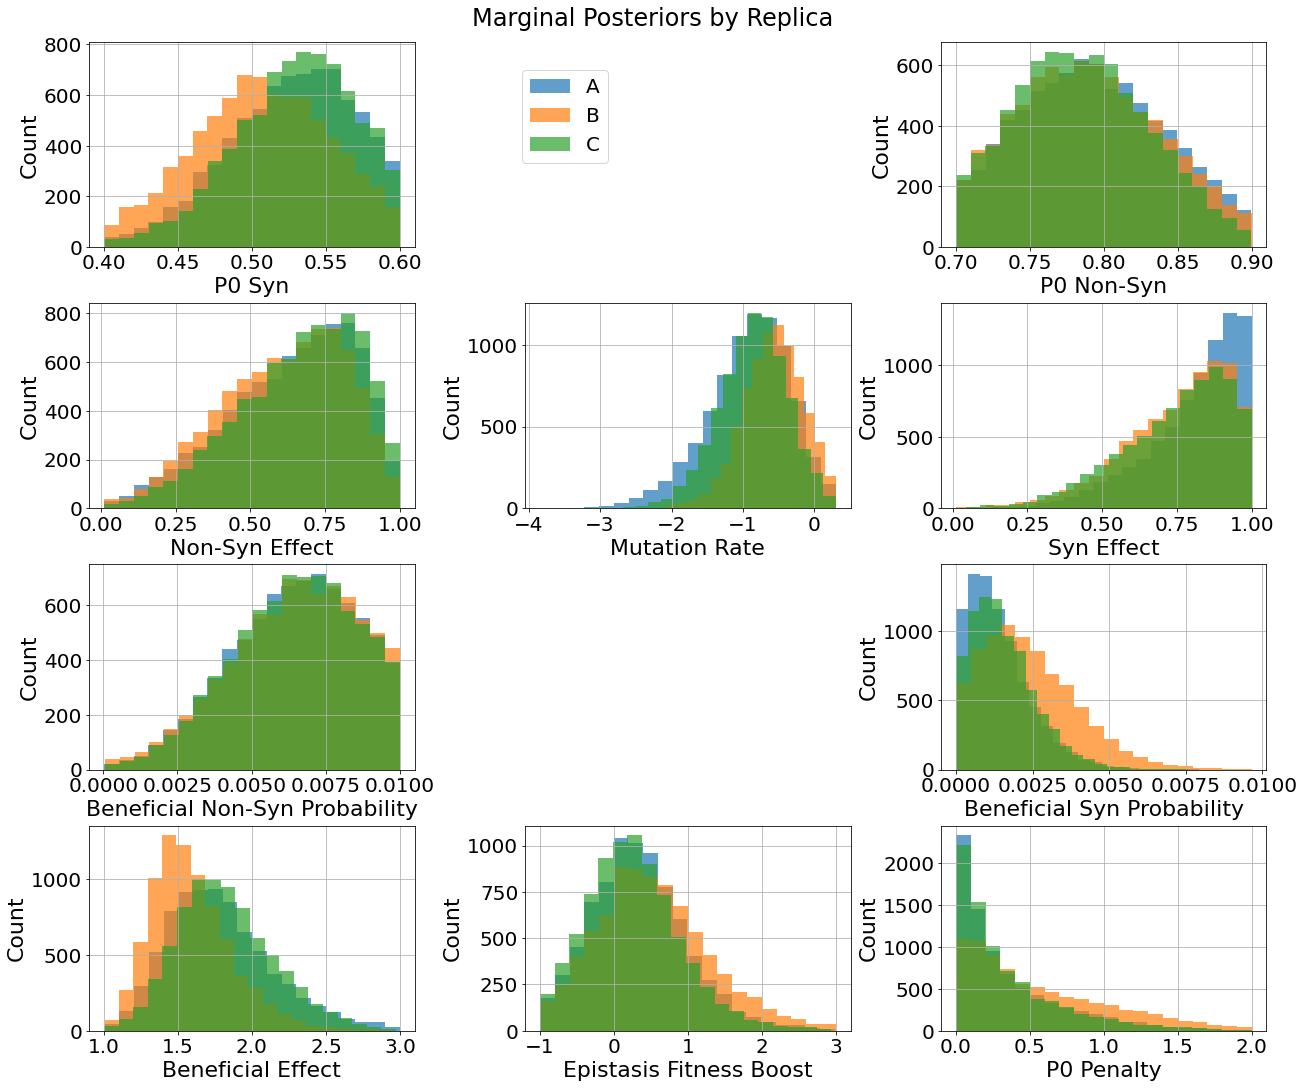

In [11]:
compare_posts_across_lines(inf_LR)

# L-LR Inference

In [12]:
inf_LLR = {}

## Figure 6

Getting posterior from sumstat:
[0.60600376 0.8208255  0.72008353 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.60600376 0.8208255  0.72008353 ... 0.         0.         0.        ]


/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.60600376 0.8208255  0.72008353 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.60600376 0.8208255  0.72008353 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.60600376 0.8208255  0.72008353 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.60600376 0.8208255  0.72008353 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.60600376 0.8208255  0.72008353 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.60600376 0.8208255  0.72008353 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.755500  -1.255726  1.642306   -0.198271  -0.915829   
1            w_syn  0.908000   0.654573  1.286754    0.999991   0.858747   
2        w_non_syn  0.677500   0.356921  0.900256    0.937751   0.622927   
3            w_ada  1.875000   1.591649  1.320960    2.262004   1.818311   
4        p_ada_syn  0.000661   0.000001  1.572732    0.002391   0.000343   
5    p_ada_non_syn  0.006000   0.002817  0.730336    0.009876   0.005003   
6           p0_syn  0.511000   0.421594  0.648411    0.592233   0.476535   
7       p0_non_syn  0.821000   0.716645  0.639069    0.890042   0.761973   
8        w_penalty  0.109950   0.000151  1.149108    0.933257   0.003342   
9  epistasis_boost -0.037050  -0.996162  0.667296    0.615134  -0.471234   

   hdi50_high     model  
0   -0.562517  ensemble  
1    0.976736  ensemble  
2    0.817367  ensemble  
3    2.033702  ensemble  
4    0.001154  ensemble  
5    0.

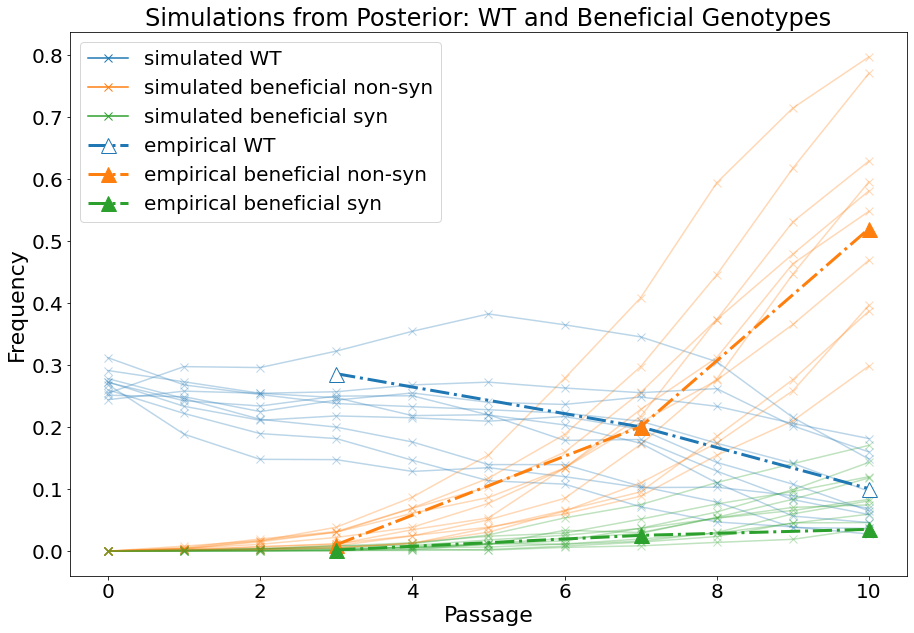

In [13]:
errs = '5e-05'
sumstat_type = 'L-LR'
replica = 'A'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=True, samples_per_model=1000, syn_prob=syn_prob)


In [14]:
errs = '5e-05'
sumstat_type = 'L-LR'
replica = 'B'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Getting posterior from sumstat:
[0.58467954 0.8066701  0.67026496 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58467954 0.8066701  0.67026496 ... 0.         0.         0.        ]


/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58467954 0.8066701  0.67026496 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58467954 0.8066701  0.67026496 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58467954 0.8066701  0.67026496 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58467954 0.8066701  0.67026496 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58467954 0.8066701  0.67026496 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58467954 0.8066701  0.67026496 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode     hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.769500 -1.298409e+00  1.792091   -0.302987  -0.894410   
1            w_syn  0.934000  7.637697e-01  1.571109    0.999997   0.900416   
2        w_non_syn  0.646500  2.094464e-01  0.818670    0.877738   0.533200   
3            w_ada  1.787000  1.542897e+00  1.361139    2.151144   1.680292   
4        p_ada_syn  0.001011  7.779253e-07  1.356785    0.003171   0.000367   
5    p_ada_non_syn  0.006770  3.152436e-03  0.755427    0.009975   0.005234   
6           p0_syn  0.527000  4.150031e-01  0.633339    0.587208   0.473168   
7       p0_non_syn  0.777000  7.059902e-01  0.658411    0.878504   0.761577   
8        w_penalty  0.149000  8.686979e-05  1.030493    1.012552   0.028060   
9  epistasis_boost -0.213000 -9.938259e-01  0.709959    0.474203  -0.539940   

   hdi50_high     model  
0   -0.566627  ensemble  
1    0.981898  ensemble  
2    0.759255  ensemble  
3    1.887298  ensemble  


In [15]:
errs = '5e-05'
sumstat_type = 'L-LR'
replica = 'C'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Getting posterior from sumstat:
[0.58097684 0.8457584  0.6399604  ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58097684 0.8457584  0.6399604  ... 0.         0.         0.        ]


/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58097684 0.8457584  0.6399604  ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58097684 0.8457584  0.6399604  ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58097684 0.8457584  0.6399604  ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58097684 0.8457584  0.6399604  ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58097684 0.8457584  0.6399604  ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58097684 0.8457584  0.6399604  ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode     hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.846500 -1.372022e+00  1.910318   -0.363643  -1.016182   
1            w_syn  0.946000  6.451735e-01  1.262659    0.999984   0.865515   
2        w_non_syn  0.550000  2.134498e-01  0.742751    0.932106   0.474342   
3            w_ada  1.899500  1.646144e+00  1.246549    2.358927   1.837025   
4        p_ada_syn  0.000537  2.048487e-07  1.704875    0.001949   0.000368   
5    p_ada_non_syn  0.005950  2.898772e-03  0.721164    0.009991   0.005161   
6           p0_syn  0.493000  4.346443e-01  0.673825    0.598977   0.491876   
7       p0_non_syn  0.785000  7.140939e-01  0.628810    0.887276   0.764842   
8        w_penalty  0.008965  1.847619e-05  1.319080    0.856284   0.000435   
9  epistasis_boost -0.361500 -9.953282e-01  0.596504    0.810094  -0.639389   

   hdi50_high     model  
0   -0.675729  ensemble  
1    0.985903  ensemble  
2    0.737771  ensemble  
3    2.081180  ensemble  


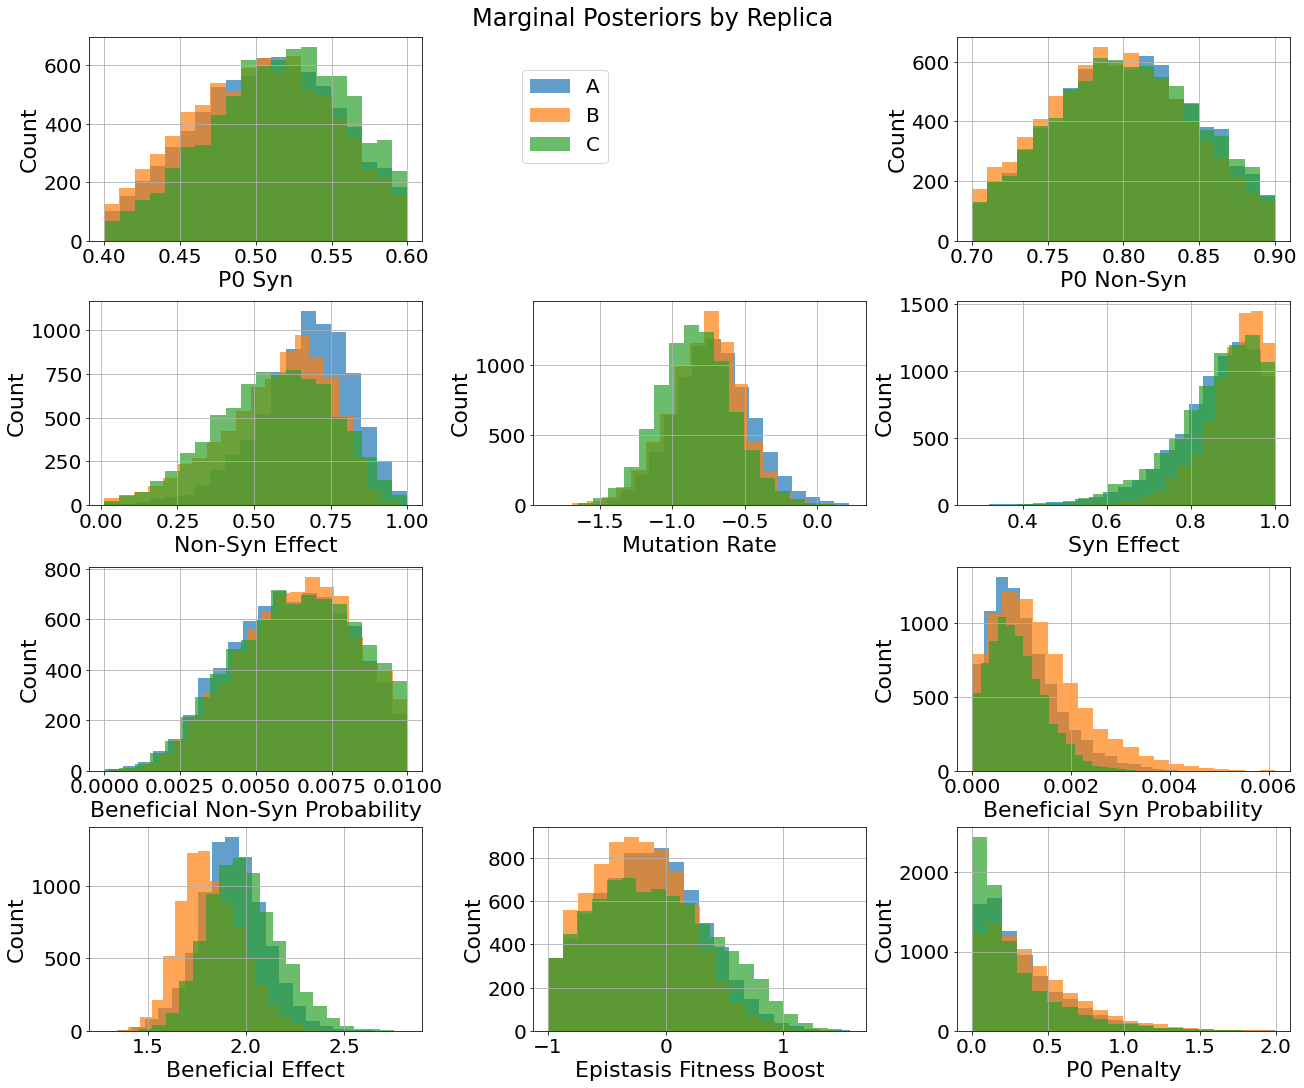

In [16]:
compare_posts_across_lines(inf_LLR)

# SR Inference

In [17]:
inf_SR = {}

In [18]:
errs = '5e-05'
sumstat_type = 'SR'
replica = 'A'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_SR[replica] = infer_and_plot(ensemble_path, loop_coding_short[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Getting posterior from sumstat:
tensor([0.6060, 0.8208, 0.7201, 1.0507, 0.7842, 1.3471])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([0.6060, 0.8208, 0.7201, 1.0507, 0.7842, 1.3471])


/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([0.6060, 0.8208, 0.7201, 1.0507, 0.7842, 1.3471])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([0.6060, 0.8208, 0.7201, 1.0507, 0.7842, 1.3471])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([0.6060, 0.8208, 0.7201, 1.0507, 0.7842, 1.3471])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([0.6060, 0.8208, 0.7201, 1.0507, 0.7842, 1.3471])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([0.6060, 0.8208, 0.7201, 1.0507, 0.7842, 1.3471])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([0.6060, 0.8208, 0.7201, 1.0507, 0.7842, 1.3471])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode     hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.655000 -1.697051e+00  1.329124    0.211099  -0.986859   
1            w_syn  0.937000  4.847950e-01  0.990356    0.999962   0.825240   
2        w_non_syn  0.688000  2.582629e-01  0.722252    0.992970   0.599937   
3            w_ada  1.931000  1.215808e+00  0.703889    2.805392   1.748961   
4        p_ada_syn  0.001550  5.630902e-07  0.903141    0.005723   0.000767   
5    p_ada_non_syn  0.007160  2.735649e-03  0.719822    0.010000   0.005805   
6           p0_syn  0.547000  4.514870e-01  0.717220    0.599983   0.519999   
7       p0_non_syn  0.781000  7.010065e-01  0.659756    0.867813   0.749385   
8        w_penalty  0.009010  1.473056e-05  1.038706    1.375930   0.000201   
9  epistasis_boost  0.019033 -9.990522e-01  0.479043    1.557125  -0.311462   

   hdi50_high     model  
0   -0.339387  ensemble  
1    0.995157  ensemble  
2    0.901306  ensemble  
3    2.337758  ensemble  


In [19]:
errs = '5e-05'
sumstat_type = 'SR'
replica = 'B'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_SR[replica] = infer_and_plot(ensemble_path, loop_coding_short[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Getting posterior from sumstat:
tensor([0.5847, 0.8067, 0.6703, 0.9504, 0.7762, 1.2092])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([0.5847, 0.8067, 0.6703, 0.9504, 0.7762, 1.2092])


/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([0.5847, 0.8067, 0.6703, 0.9504, 0.7762, 1.2092])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([0.5847, 0.8067, 0.6703, 0.9504, 0.7762, 1.2092])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([0.5847, 0.8067, 0.6703, 0.9504, 0.7762, 1.2092])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([0.5847, 0.8067, 0.6703, 0.9504, 0.7762, 1.2092])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([0.5847, 0.8067, 0.6703, 0.9504, 0.7762, 1.2092])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([0.5847, 0.8067, 0.6703, 0.9504, 0.7762, 1.2092])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param     mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.76200  -1.860016  1.351329    0.196022  -1.103162   
1            w_syn  0.92600   0.435969  0.923321    0.999984   0.795280   
2        w_non_syn  0.71750   0.198307  0.704787    0.968805   0.572655   
3            w_ada  2.09000   1.270254  0.698654    2.871656   1.806897   
4        p_ada_syn  0.00241   0.000030  0.865000    0.006272   0.001287   
5    p_ada_non_syn  0.00718   0.002585  0.719013    0.009999   0.005327   
6           p0_syn  0.55700   0.447709  0.714809    0.599932   0.514705   
7       p0_non_syn  0.77300   0.700030  0.662784    0.867596   0.744583   
8        w_penalty  0.03010   0.000175  1.027375    1.311420   0.000838   
9  epistasis_boost  0.13250  -0.999335  0.503471    1.398084  -0.475399   

   hdi50_high     model  
0   -0.370412  ensemble  
1    0.988298  ensemble  
2    0.874398  ensemble  
3    2.417758  ensemble  
4    0.003447  ensemble  
5    0.008321  ens

In [20]:
errs = '5e-05'
sumstat_type = 'SR'
replica = 'C'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_SR[replica] = infer_and_plot(ensemble_path, loop_coding_short[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Getting posterior from sumstat:
tensor([0.5810, 0.8458, 0.6400, 1.0010, 0.7792, 1.3856])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([0.5810, 0.8458, 0.6400, 1.0010, 0.7792, 1.3856])


/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([0.5810, 0.8458, 0.6400, 1.0010, 0.7792, 1.3856])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([0.5810, 0.8458, 0.6400, 1.0010, 0.7792, 1.3856])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([0.5810, 0.8458, 0.6400, 1.0010, 0.7792, 1.3856])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([0.5810, 0.8458, 0.6400, 1.0010, 0.7792, 1.3856])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([0.5810, 0.8458, 0.6400, 1.0010, 0.7792, 1.3856])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
tensor([0.5810, 0.8458, 0.6400, 1.0010, 0.7792, 1.3856])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.682500  -1.766688  1.321973    0.221439  -1.064752   
1            w_syn  0.906500   0.415251  0.883787    0.999938   0.753989   
2        w_non_syn  0.639000   0.274850  0.708070    0.990079   0.591084   
3            w_ada  1.911000   1.359633  0.689495    2.929581   1.801819   
4        p_ada_syn  0.001750   0.000005  0.913517    0.005724   0.001094   
5    p_ada_non_syn  0.007460   0.002654  0.706685    0.009997   0.006165   
6           p0_syn  0.547000   0.448830  0.711604    0.599841   0.508421   
7       p0_non_syn  0.781000   0.700291  0.648262    0.865374   0.748567   
8        w_penalty  0.030000   0.000031  1.021971    1.347735   0.000166   
9  epistasis_boost -0.022075  -0.999010  0.542488    1.222845  -0.410833   

   hdi50_high     model  
0   -0.318864  ensemble  
1    0.959098  ensemble  
2    0.887200  ensemble  
3    2.407935  ensemble  
4    0.003124  ensemble  
5    0.

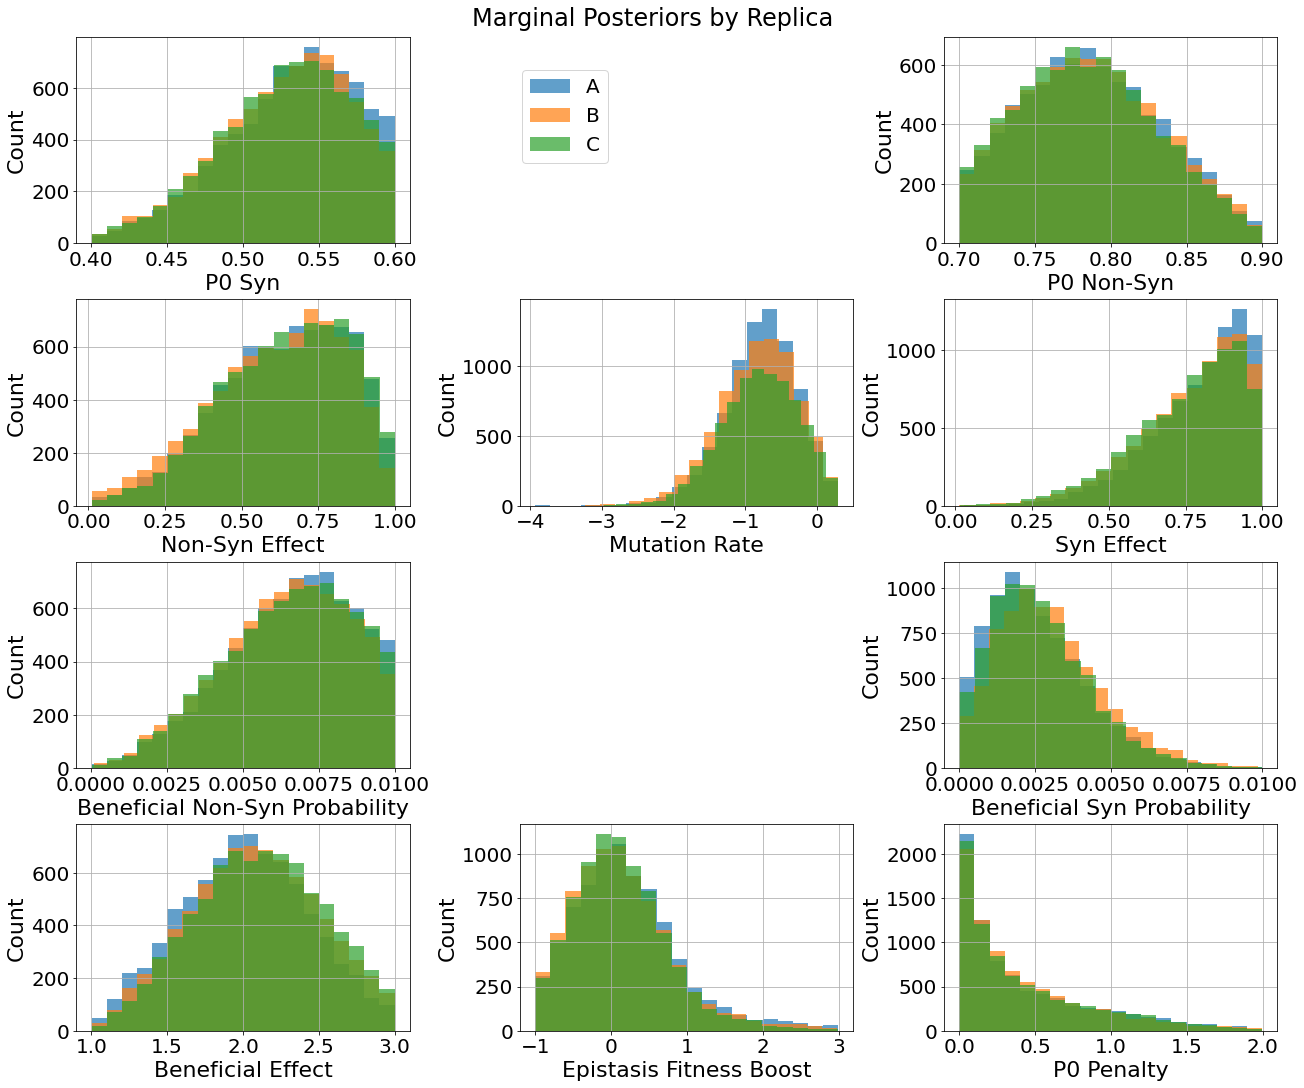

In [21]:
compare_posts_across_lines(inf_SR)

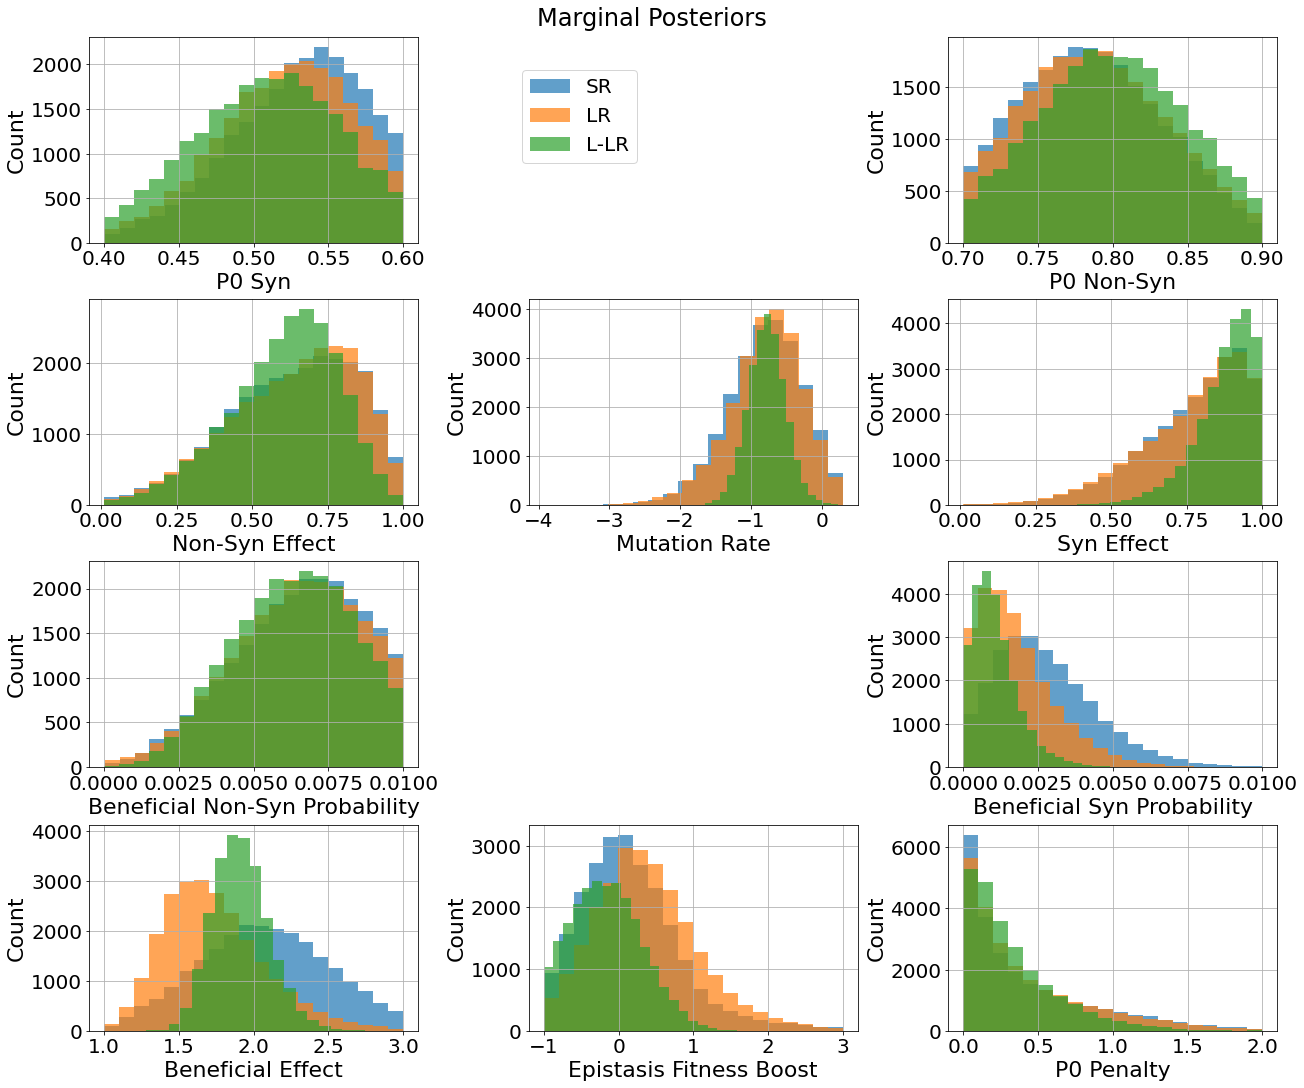

In [22]:
all_posts = {'SR': pd.concat([x[0] for x in inf_SR.values()]),
             'LR': pd.concat([x[0] for x in inf_LR.values()]),
             'L-LR': pd.concat([x[0] for x in inf_LLR.values()])}
compare_posts(all_posts)

In [23]:
def compare_posts_for_paper(posts, title_suffix='', colors=None, alpha=0.7, mu_xticks=(-3,1)):
    fig, axes = plt.subplots(3, 3, figsize=(18,15), constrained_layout=True)
    ax_dict = {'Mutation\nRate': (0,1), 'Syn\nEffect': (0,2), 'Non-Syn\nEffect': (0,0), 
               'Beneficial\nEffect': (2,0), 'P0 Penalty': (2,2), 
               'Epistasis\nFitness\nBoost': (2,1), 
               'Beneficial\nSyn\nProbability': (1,2), 'Beneficial\nNon-Syn\nProbability': (1,0)}
    if not colors:
        colors = sns.color_palette(None)
    title = 'Marginal Posteriors'
    title += title_suffix
    #fig.suptitle(title)
    legend = True
    for col_name, ax_index in ax_dict.items():
        ax = axes[ax_index]
        col = 'err' if 'Mutation' in col_name else 'rel_err'
        for i, (name, df) in enumerate(posts.items()):
            df[col_name].hist(bins=20, label=name if legend else '_nolegend', ax=ax, alpha=alpha, color=colors[i])
            if 'Mutation' in col_name:
                xticks = range(mu_xticks[0],mu_xticks[1])
                ax.set_xticks(xticks)
                ax.set_xticklabels([10**x for x in xticks])
            if 'Probability' in col_name:
                ax.set_xticks([0, 0.005, 0.01])
                #ax.set_xticklabels([10**x for x in xticks])
            if 'stasis' in col_name:
                ax.axvline(0.5, ls='--', color='k')    
        ax.set_xlabel(col_name.replace('\n', ' '))
        if 'Penalty' in col_name:
            ax.set_xlabel('P0 log-fitness Correlation')
        ax.set_ylabel('Count')
        legend = False
    fig.delaxes(axes[(1,1)])
    #fig.delaxes(axes[(2,1)])
    fig.legend(loc=(0.46,0.46))


## Fig 5B

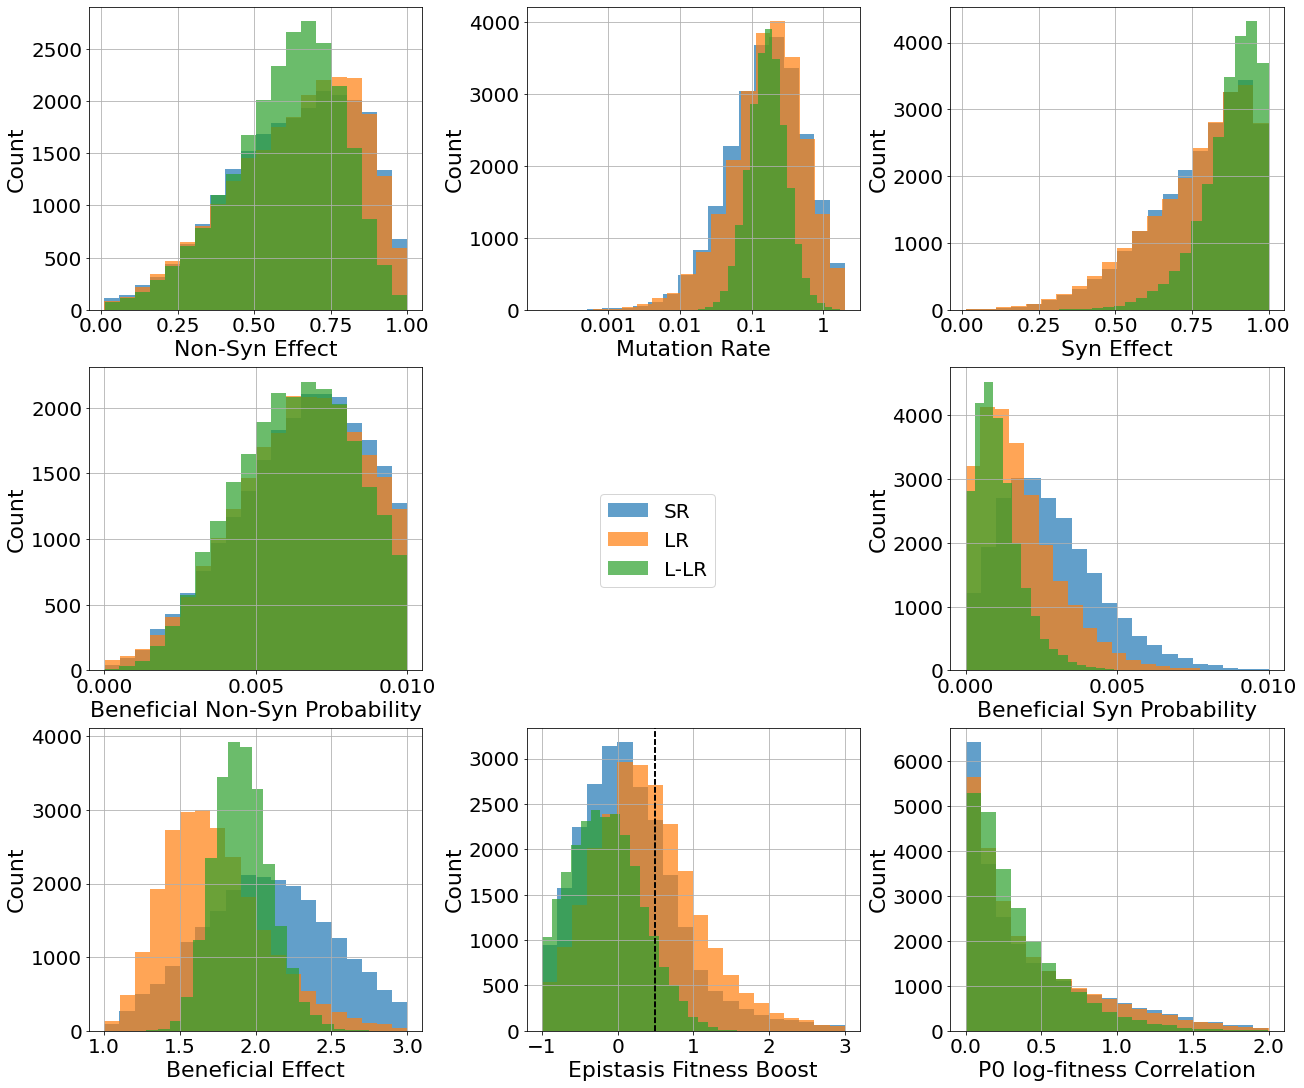

In [24]:
compare_posts_for_paper({'SR': all_posts['SR'], 'LR': all_posts['LR'], 'L-LR': all_posts['L-LR']})

## Table 1 + Table S2 data

In [25]:
all_posts_tmp = {k :v.rename(columns={v:k for k,v in rename_dict.items()}) for k,v in all_posts.items()}
stats = {k : calc_stats(v, None, prior) for k,v in all_posts_tmp.items()}
for k, v in stats.items():
    for param in v.param.unique():
        print(k)
        print(param)
        print(v[v.param==param][['hdi95_low', 'mode', 'hdi95_high']])

/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


SR
mu
   hdi95_low   mode  hdi95_high
0  -1.791809 -0.736    0.204852
SR
w_syn
   hdi95_low   mode  hdi95_high
1   0.442321  0.926    0.999984
SR
w_non_syn
   hdi95_low   mode  hdi95_high
2   0.231608  0.717    0.976584
SR
w_ada
   hdi95_low   mode  hdi95_high
3   1.270254  1.911    2.872539
SR
p_ada_syn
      hdi95_low     mode  hdi95_high
4  7.064568e-07  0.00155    0.005932
SR
p_ada_non_syn
   hdi95_low     mode  hdi95_high
5   0.002653  0.00716        0.01
SR
p0_syn
   hdi95_low   mode  hdi95_high
6   0.449193  0.547    0.599983
SR
p0_non_syn
   hdi95_low   mode  hdi95_high
7   0.700288  0.781    0.866933
SR
w_penalty
   hdi95_low  mode  hdi95_high
8   0.000015  0.03    1.347735
SR
epistasis_boost
   hdi95_low     mode  hdi95_high
9  -0.999335  0.05875    1.403641
LR
mu
   hdi95_low    mode  hdi95_high
0  -1.815508 -0.6745    0.170179
LR
w_syn
   hdi95_low   mode  hdi95_high
1    0.43027  0.896    0.999995
LR
w_non_syn
   hdi95_low   mode  hdi95_high
2   0.242501  0.787    0.982832

## Fig 5A

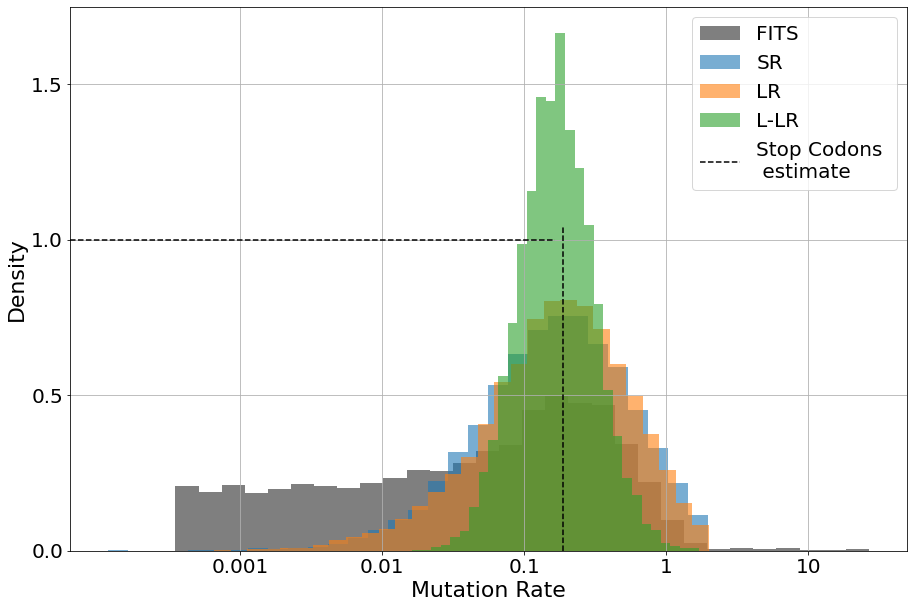

In [26]:
fits_post = pd.read_table('../MS2/analyses/FITS/fits_post.tsv')
sample_size = 10000
bin_num = 30
alpha = 0.6
fits_post.log_U.sample(sample_size).hist(bins=bin_num, label='FITS', density=True, color=sns.color_palette()[7])
all_posts['SR']['Mutation\nRate'].sample(sample_size).hist(bins=bin_num, alpha=alpha, label='SR', density=True)
all_posts['LR']['Mutation\nRate'].sample(sample_size).hist(bins=bin_num, alpha=alpha, label='LR', density=True)
all_posts['L-LR']['Mutation\nRate'].sample(sample_size).hist(bins=bin_num, alpha=alpha, label='L-LR', density=True)
plt.ylabel('Density')
plt.legend()#loc=(1.1,0.8))

#plt.title('Mutation Rate Marginal Posterior')
plt.xlabel('Mutation Rate')
xticks = [-3,-2,-1,0, 1]
plt.xticks(xticks, labels=[10**x for x in xticks])
plt.yticks([0,0.5,1,1.5])
stop_codon_estimate = np.log10(0.187)
plt.axvline(stop_codon_estimate, ls='--', color='k', ymax=0.595)
plt.axhline(1, xmax=0.579, ls='--', color='k')
handles, labels = plt.gca().get_legend_handles_labels()
line = plt.Line2D([0], [0], label='Stop Codons \n estimate', color='k', ls='--')
handles.extend([line])
plt.legend(handles=handles)


# Large Errors (10x loop errs)

In [27]:
large_errs_LLR = {}

In [28]:
errs = '0.0005'
replica = 'A'
sumstat_type = 'L-LR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

Getting posterior from sumstat:
[0.60600376 0.8208255  0.72008353 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Getting posterior from sumstat:
[0.60600376 0.8208255  0.72008353 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.60600376 0.8208255  0.72008353 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.60600376 0.8208255  0.72008353 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.60600376 0.8208255  0.72008353 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.60600376 0.8208255  0.72008353 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.60600376 0.8208255  0.72008353 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.60600376 0.8208255  0.72008353 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.604000  -1.158324  1.466469   -0.099196  -0.803572   
1            w_syn  0.847500   0.576241  1.196887    0.958672   0.747504   
2        w_non_syn  0.329500   0.096014  0.820470    0.724153   0.279145   
3            w_ada  1.765000   1.520911  1.398792    2.099860   1.675379   
4        p_ada_syn  0.000981   0.000084  1.836615    0.001820   0.000623   
5    p_ada_non_syn  0.006965   0.004211  0.855274    0.009997   0.006341   
6           p0_syn  0.497000   0.416007  0.646080    0.589974   0.467379   
7       p0_non_syn  0.797000   0.708506  0.655225    0.882311   0.766136   
8        w_penalty  0.367000   0.021398  0.768317    1.492822   0.203581   
9  epistasis_boost -0.677000  -0.999129  0.681328    0.501096  -0.681801   

   hdi50_high     model  
0   -0.464392  ensemble  
1    0.878684  ensemble  
2    0.513796  ensemble  
3    1.878856  ensemble  
4    0.001225  ensemble  
5    0.

In [29]:
errs = '0.0005'
replica = 'B'
sumstat_type = 'L-LR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

Getting posterior from sumstat:
[0.58467954 0.8066701  0.67026496 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Getting posterior from sumstat:
[0.58467954 0.8066701  0.67026496 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58467954 0.8066701  0.67026496 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58467954 0.8066701  0.67026496 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58467954 0.8066701  0.67026496 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58467954 0.8066701  0.67026496 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58467954 0.8066701  0.67026496 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58467954 0.8066701  0.67026496 ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode     hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.283500 -7.734963e-01  0.856759    0.241952  -0.440091   
1            w_syn  0.640500  4.233713e-01  1.161045    0.836389   0.598640   
2        w_non_syn  0.218000  1.094152e-02  1.053500    0.429648   0.110240   
3            w_ada  1.736000  1.496974e+00  1.424838    2.065766   1.662022   
4        p_ada_syn  0.000635  2.903923e-07  1.701671    0.002012   0.000172   
5    p_ada_non_syn  0.001615  2.535812e-06  1.070919    0.005368   0.001122   
6           p0_syn  0.473000  4.052055e-01  0.644654    0.578607   0.461025   
7       p0_non_syn  0.815000  7.021961e-01  0.637641    0.877011   0.761526   
8        w_penalty  1.951000  8.627343e-01  0.928470    1.999873   1.607916   
9  epistasis_boost -0.132000 -9.963766e-01  0.673596    0.655080  -0.520373   

   hdi50_high     model  
0   -0.083981  ensemble  
1    0.732630  ensemble  
2    0.284162  ensemble  
3    1.859948  ensemble  


In [30]:
errs = '0.0005'
replica = 'C'
sumstat_type = 'L-LR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

Getting posterior from sumstat:
[0.58097684 0.8457584  0.6399604  ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/full_genome_modeling/utils.py:61: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Getting posterior from sumstat:
[0.58097684 0.8457584  0.6399604  ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58097684 0.8457584  0.6399604  ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58097684 0.8457584  0.6399604  ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58097684 0.8457584  0.6399604  ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58097684 0.8457584  0.6399604  ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58097684 0.8457584  0.6399604  ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Getting posterior from sumstat:
[0.58097684 0.8457584  0.6399604  ... 0.         0.         0.        ]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode     hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.739000 -1.226967e+00  1.569700   -0.152498  -0.860000   
1            w_syn  0.821500  6.206146e-01  1.247753    0.980411   0.767272   
2        w_non_syn  0.264000  2.806300e-02  0.973714    0.532516   0.195959   
3            w_ada  2.018500  1.642362e+00  1.301716    2.332101   1.878208   
4        p_ada_syn  0.000494  1.096817e-08  1.829219    0.001668   0.000395   
5    p_ada_non_syn  0.004070  1.669153e-03  0.876641    0.007737   0.003093   
6           p0_syn  0.493000  4.106223e-01  0.634517    0.584712   0.457523   
7       p0_non_syn  0.797000  7.089455e-01  0.624883    0.883895   0.761509   
8        w_penalty  1.423000  6.117219e-01  0.755486    1.999698   1.160466   
9  epistasis_boost -0.246000 -9.956296e-01  0.681797    0.553736  -0.529062   

   hdi50_high     model  
0   -0.497256  ensemble  
1    0.888135  ensemble  
2    0.384566  ensemble  
3    2.095185  ensemble  


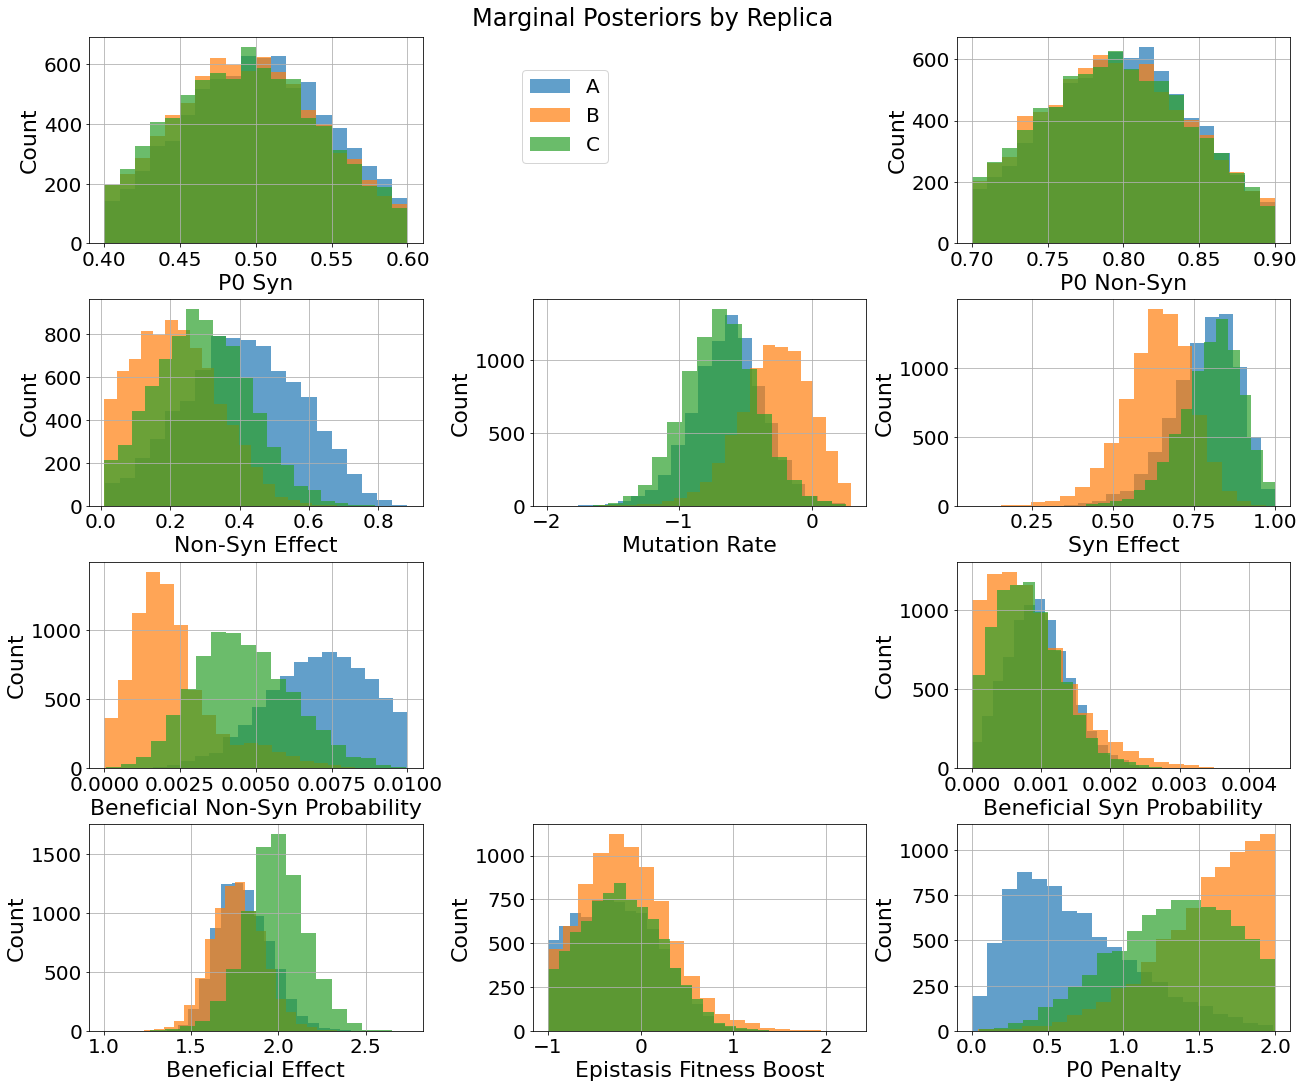

In [31]:
compare_posts_across_lines(large_errs_LLR)

## Fig S4

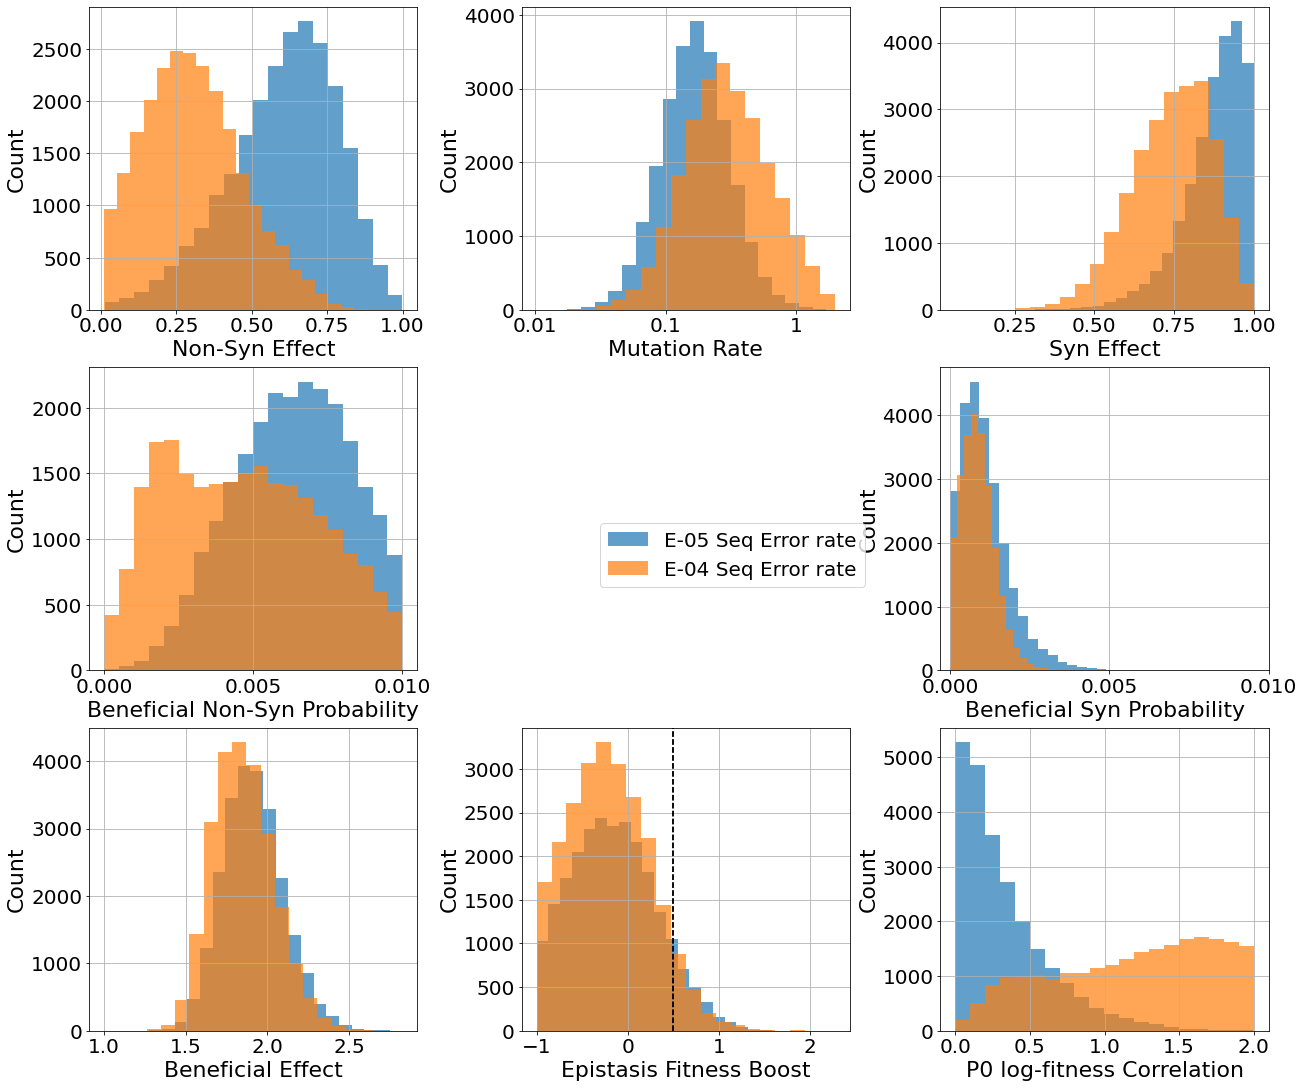

In [32]:
man_errs = {'E-05 Seq Error rate': pd.concat([x[0] for x in inf_LLR.values()]),
            'E-04 Seq Error rate': pd.concat([x[0] for x in large_errs_LLR.values()])}
compare_posts_for_paper(man_errs, mu_xticks=(-2,1))

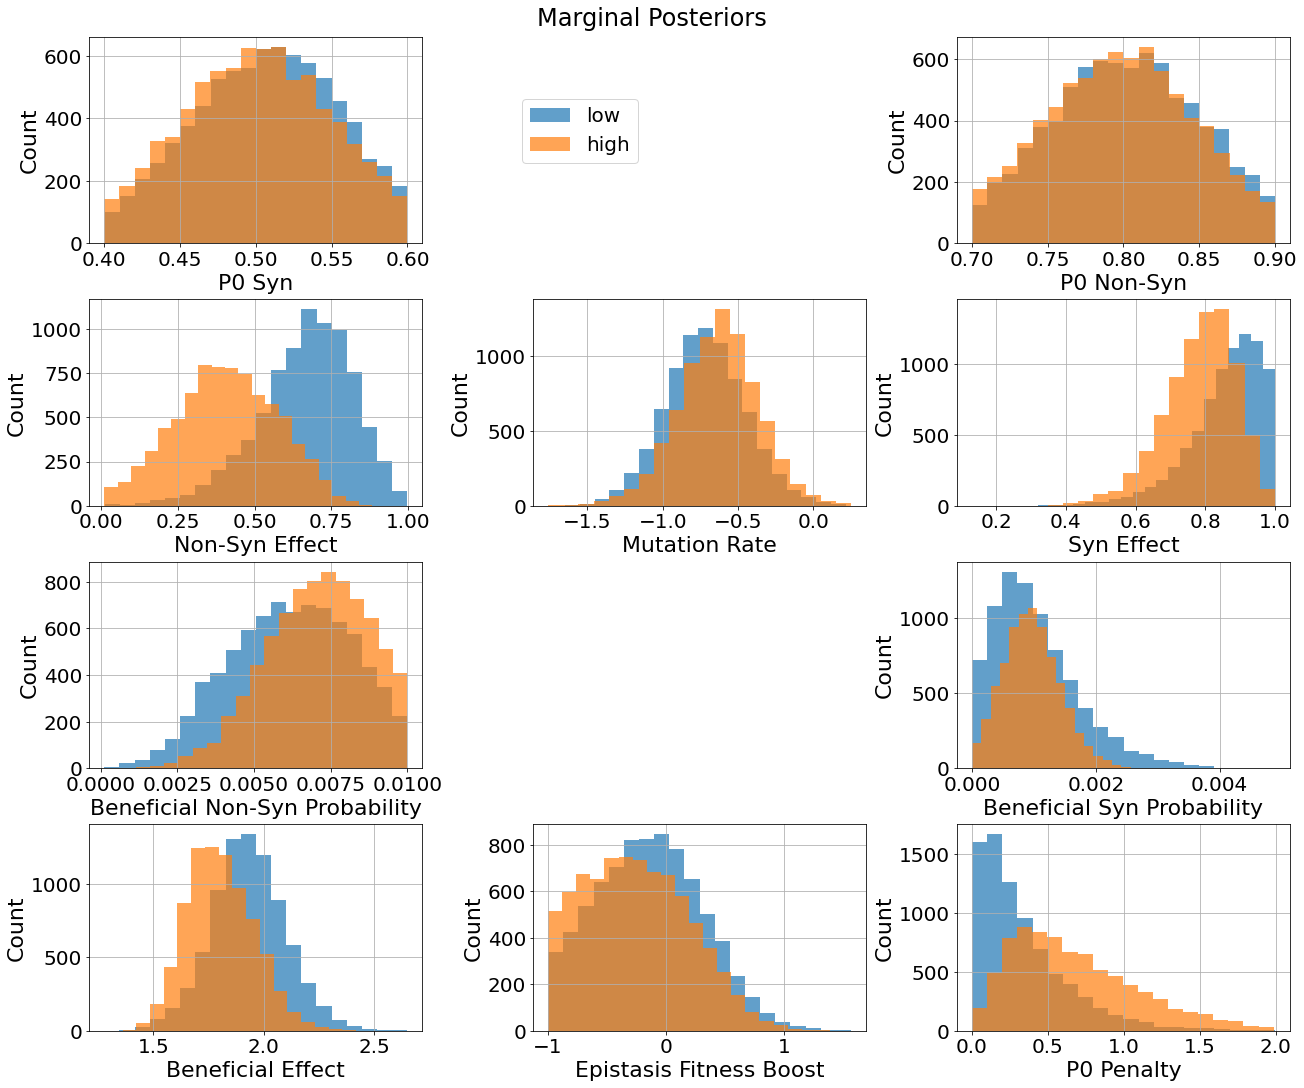

In [33]:
replica = 'A'
compare_posts({'low': inf_LLR[replica][0], 'high': large_errs_LLR[replica][0]})

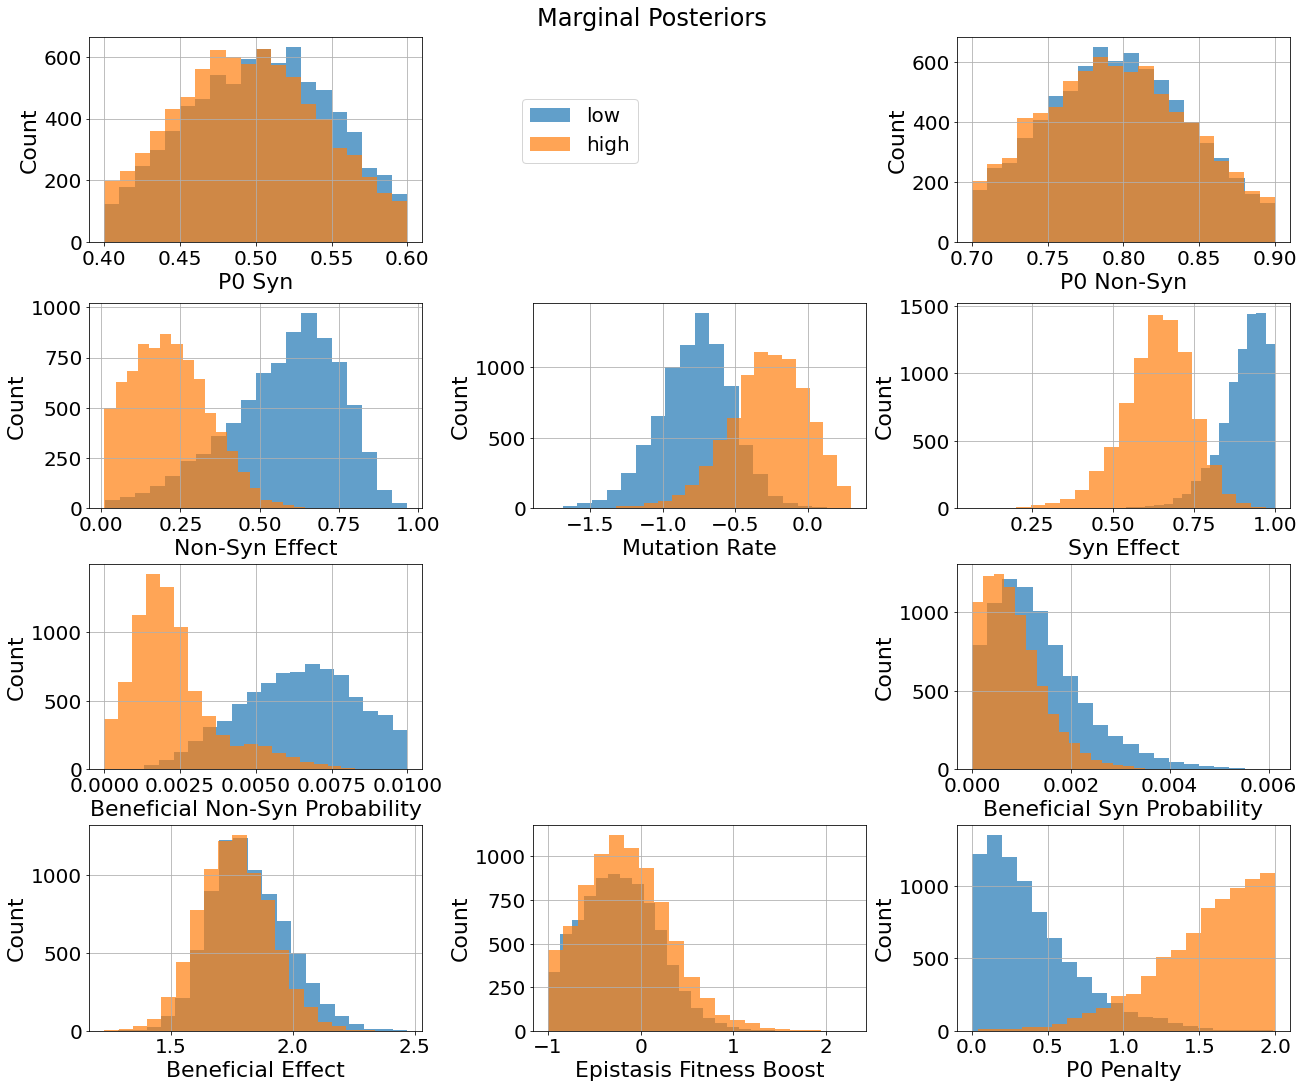

In [34]:
replica = 'B'
compare_posts({'low': inf_LLR[replica][0], 'high': large_errs_LLR[replica][0]})

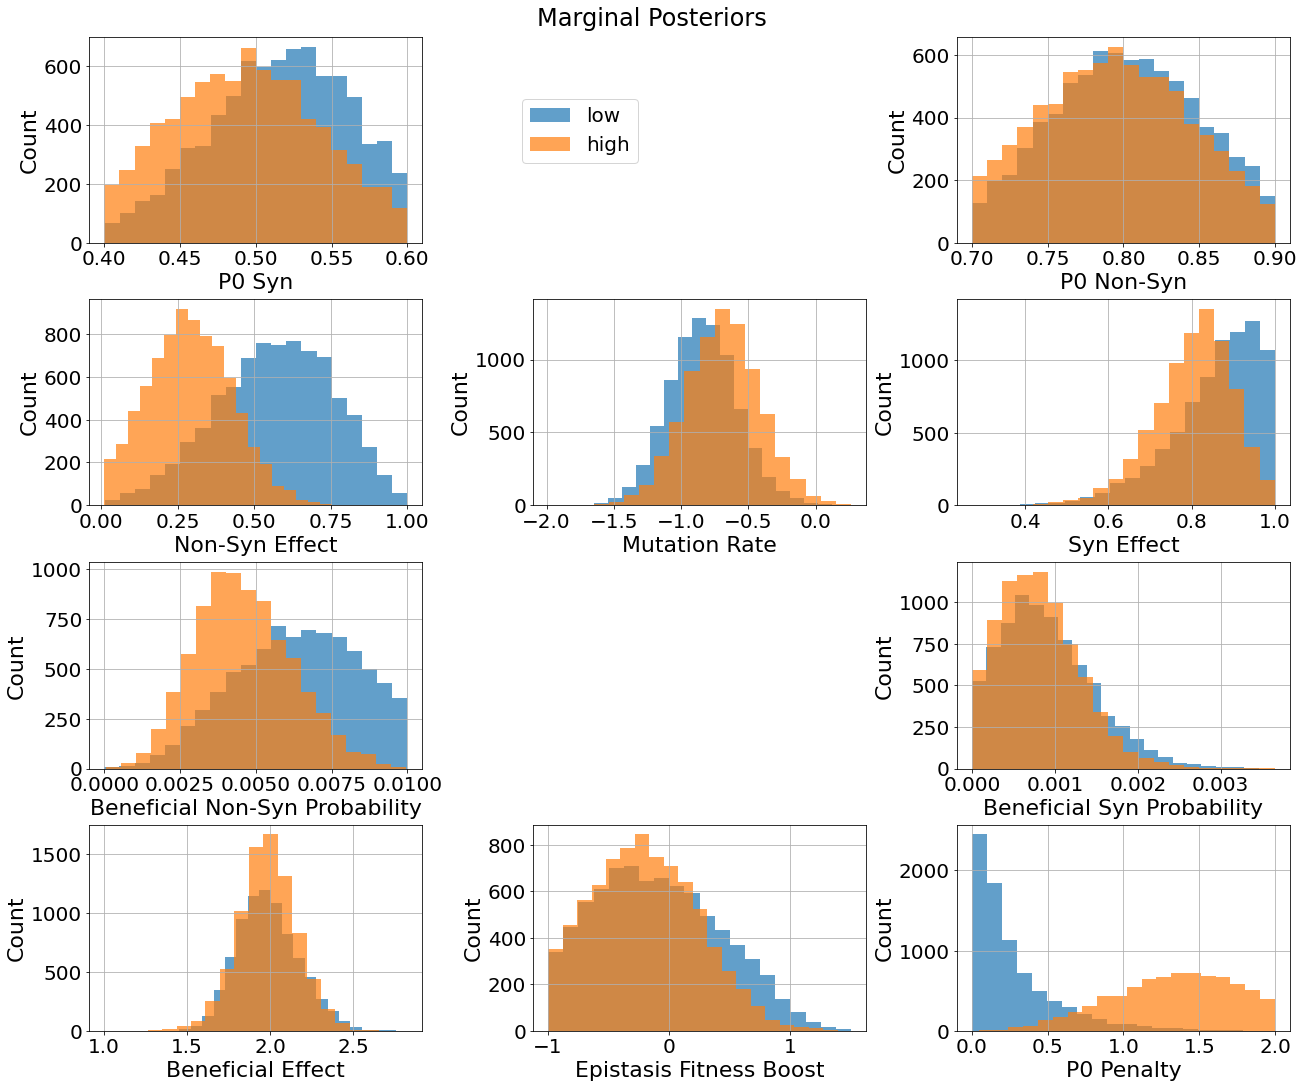

In [35]:
replica = 'C'
compare_posts({'low': inf_LLR[replica][0], 'high': large_errs_LLR[replica][0]})